In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
#from pandas.plotting import register_matplotlib_convertersd
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
#register_matplotlib_converters()
from time import time

import warnings
warnings.filterwarnings('ignore')

# S&P 500 Data

In [2]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [3]:
#read data
stock_data = pd.read_csv('Data\spy_data.csv', parse_dates=[0], index_col='Date', date_parser=parser)

In [4]:
#infer the frequency of the data
data = stock_data
data = data.asfreq(pd.infer_freq(data.index))
#drop the NA data and reindex
data = data.dropna()
data.reindex()
data

,Close
Date,
2012-01-03,127.500000
2012-01-04,127.699997
2012-01-05,128.039993
2012-01-06,127.709999
2012-01-09,128.020004
...,...
2022-10-21,374.290009
2022-10-24,378.869995
2022-10-25,384.920013


In [5]:
#check to see no NA data
data['Close'].isna().sum()

0

In [6]:
stock_price = data['Close']

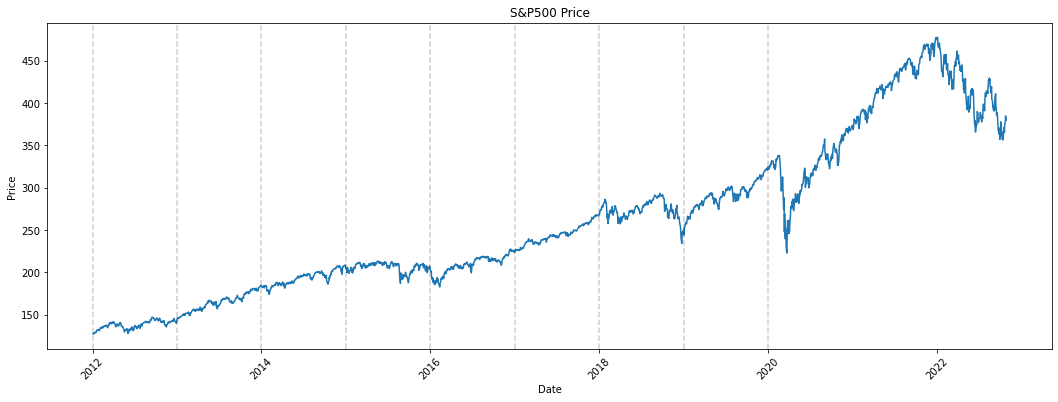

In [7]:
#plot the data
plt.figure(figsize=(18,6))
plt.plot(data.index, stock_price)
plt.title("S&P500 Price")
plt.xlabel("Date")
plt.ylabel("Price")

for year in range(2012, 2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

plt.xticks(rotation=45)
plt.show()

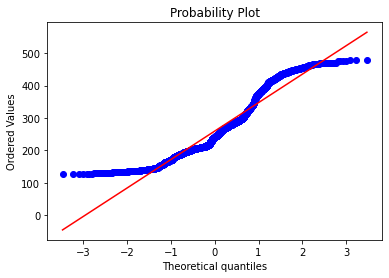

In [8]:
#plot QQ plot
import scipy.stats
scipy.stats.probplot(stock_price, plot = plt)
plt.show()

In [9]:
#As the plot shows that there are more data points at 100, this is not a normally distributed as it is expected from a
#time series data. Normally distributed data should follow the the redline. Theoretical quantiles means how many standard
#deviation away from the mean a data point is located.

In [10]:
stock_price.describe()

count    2724.000000
mean      259.606428
std        90.815752
min       127.500000
25%       194.759998
50%       240.529999
75%       307.062492
max       477.709991
Name: Close, dtype: float64

In [11]:
#check for stationarity
# ADF Test before differencing
adf = adfuller(stock_price,12)
print("\nStatistics analysis\n")
print("Statistic Test : " , adf[0])
print("p-value : " , adf[1])
print("# n_lags : " , adf[2])
print("No of observation: " , adf[3])
for key,value in adf[4].items():
    print(f" critical value {key} : {value}")


Statistics analysis

Statistic Test :  -0.9280804877164516
p-value :  0.7785845325112005
# n_lags :  11
No of observation:  2712
 critical value 1% : -3.43276353256931
 critical value 5% : -2.8626063225123146
 critical value 10% : -2.5673376385571394


In [12]:
#statistics test value is greater than the critical values and p value is higher than .05
#this is not a stationary data

In [13]:
#take first difference
data = stock_price.diff()
data = data.drop(data.index[0])

#check for stationarity
# ADF Test before differencing
adf = adfuller(data,12)
print("\nStatistics analysis\n")
print("Statistic Test : " , adf[0])
print("p-value : " , adf[1])
print("# n_lags : " , adf[2])
print("No of observation: " , adf[3])
for key,value in adf[4].items():
    print(f" critical value {key} : {value}")


Statistics analysis

Statistic Test :  -14.697521067369886
p-value :  2.9821595003252456e-27
# n_lags :  12
No of observation:  2710
 critical value 1% : -3.432765315465621
 critical value 5% : -2.8626071098943244
 critical value 10% : -2.5673380577606513


In [14]:
#statistics test value is lower than the critical values and p value is lower than .05
#this is a stationary data

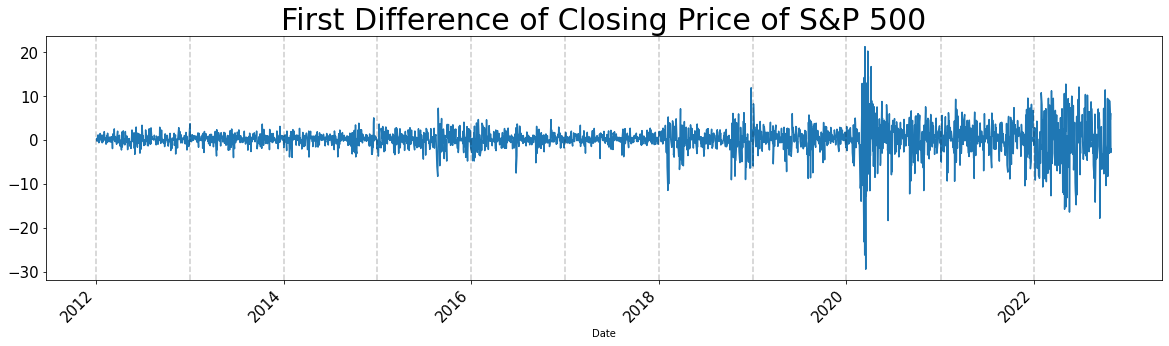

In [15]:
data.plot(figsize = (20,5), fontsize = 15)
plt.title("First Difference of Closing Price of S&P 500", fontsize = 30)

for year in range(2012, 2023):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.xticks(rotation=45)
plt.show()

In [16]:
#since difference data is stationary we can plot ACF and PACF

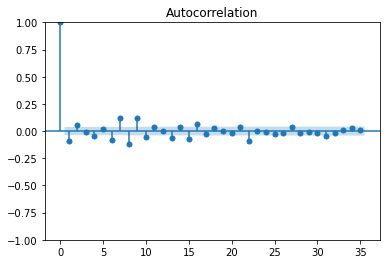

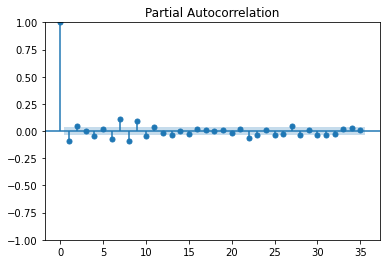

In [17]:
plot_acf(data);
plot_pacf(data);

In [18]:
#split test and train data
train_data = data[data.index < pd.to_datetime("2022-10-21", format='%Y-%m-%d')]
test_data = data[data.index > pd.to_datetime("2022-10-20", format='%Y-%m-%d')]

In [19]:
train_data

Date
2012-01-04    0.199997
2012-01-05    0.339996
2012-01-06   -0.329994
2012-01-09    0.310005
2012-01-10    1.110001
                ...   
2022-10-14   -8.339996
2022-10-17    9.190002
2022-10-18    4.309998
2022-10-19   -2.630005
2022-10-20   -3.089996
Name: Close, Length: 2718, dtype: float64

In [20]:
test_data

Date
2022-10-21    8.880005
2022-10-24    4.579987
2022-10-25    6.050018
2022-10-26   -2.900024
2022-10-27   -2.039978
Name: Close, dtype: float64

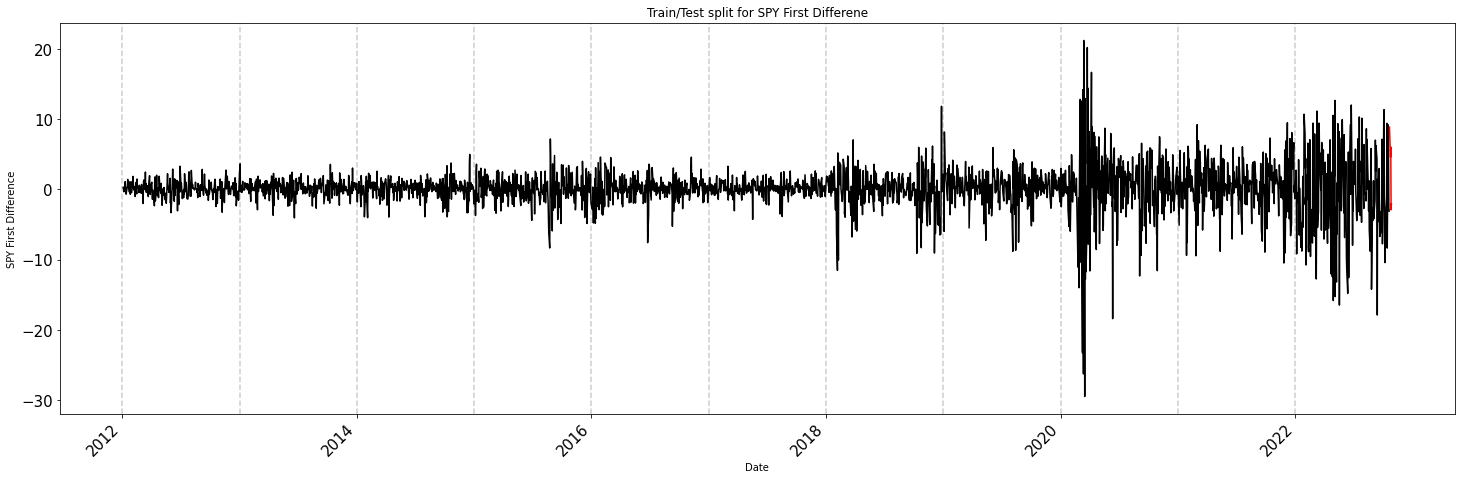

In [21]:
#plot the data
train_data.plot(figsize = (25,8), color = "black", fontsize = 15)
test_data.plot(figsize = (25,8), color = "red", fontsize = 15)
plt.ylabel('SPY First Difference')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for SPY First Differene")
for year in range(2012, 2023):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.show()

In [22]:
# train autoregression
model = AutoReg(train_data, lags=5)
model_fit = model.fit()
coef = model_fit.params
print('Coefficients: %s' % model_fit.params)

Coefficients: const       0.093420
Close.L1   -0.088763
Close.L2    0.053389
Close.L3   -0.005808
Close.L4   -0.048236
Close.L5    0.015346
dtype: float64


In [23]:
# make predictions
predictions = model_fit.predict(start=len(train_data), end=len(train_data)+len(test_data)-1, dynamic=False)

In [24]:
predictions.index = test_data.index

In [25]:
#print predictions
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test_data[i]))

predicted=-0.369024, expected=8.880005
predicted=-0.090394, expected=4.579987
predicted=0.292690, expected=6.050018
predicted=0.173448, expected=-2.900024
predicted=0.064558, expected=-2.039978


In [26]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(test_data, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 5.557


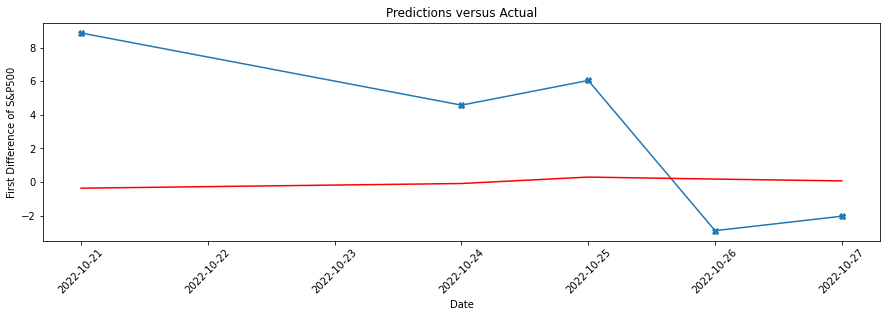

In [27]:
# plot results
plt.figure(figsize=(15,4))
plt.plot(test_data, marker="X")
plt.plot(predictions, color='red')
plt.title("Predictions versus Actual")
plt.xlabel("Date")
plt.ylabel("First Difference of S&P500")
plt.xticks(rotation=45)
plt.show()

In [28]:
data

Date
2012-01-04    0.199997
2012-01-05    0.339996
2012-01-06   -0.329994
2012-01-09    0.310005
2012-01-10    1.110001
                ...   
2022-10-21    8.880005
2022-10-24    4.579987
2022-10-25    6.050018
2022-10-26   -2.900024
2022-10-27   -2.039978
Name: Close, Length: 2723, dtype: float64

In [29]:
# make a copy dataset
rolling_data = data.copy()
X = rolling_data

In [30]:
n_forecast = 5
predictions_rolling = X[len(X)-n_forecast:]
test_rolling = data[len(X)-n_forecast:]

In [31]:
for end in range(n_forecast):
    X = data.copy()
    train = X[:len(X)-n_forecast+end]
    model_rolling = AutoReg(train, lags=5)
    model_rolling_fit = model_rolling.fit()
    predictions_rolling[end] = model_rolling_fit.predict(start=len(train), end=len(train), dynamic=False)

In [32]:
#print predictions
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions_rolling[i], test_rolling[i]))

predicted=-0.369024, expected=8.880005
predicted=-0.934806, expected=4.579987
predicted=0.346301, expected=6.050018
predicted=-0.130688, expected=-2.900024
predicted=0.202607, expected=-2.039978


In [33]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(test_rolling, predictions_rolling))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 5.678


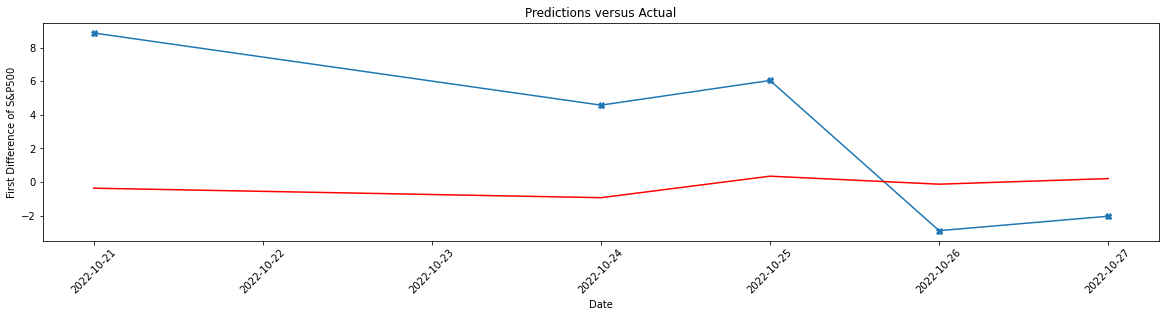

In [34]:
plt.figure(figsize=(20,4))
plt.plot(test_rolling, marker="X")
plt.plot(predictions_rolling, color='red')
plt.title("Predictions versus Actual")
plt.xlabel("Date")
plt.ylabel("First Difference of S&P500")
plt.xticks(rotation=45)
plt.show()